In [16]:
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

# Define parametrs

In [18]:
WEIGHT_PATH = 'weight'
VIDEO_FOLDER = "samples"

load_epoch = 28

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.get_device_name()
device

'cpu'

# Model

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(nn.ReflectionPad2d(1),
                                   nn.Conv2d(in_features, in_features, 3),
                                   nn.InstanceNorm2d(in_features),
                                    nn.ReLU(inplace=True),
                                    nn.ReflectionPad2d(1),
                                    nn.Conv2d(in_features, in_features, 3),
                                    nn.InstanceNorm2d(in_features))

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels = 3, n_residual_blocks = 3, n_conv_blocks = 3):
        super(Generator, self).__init__()

        out_features = 256 // (2  ** (n_conv_blocks-1)) # 64

        model = [nn.ReflectionPad2d(in_channels),
                 nn.Conv2d(in_channels, out_features, 7),
                 nn.InstanceNorm2d(out_features),
                 nn.ReLU(inplace=True)]

        n_conv_blocks -= 1
        in_features = out_features

        for _ in range(n_conv_blocks):
            out_features = 2 * in_features
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True)]
            in_features = out_features

        for _ in range(n_residual_blocks):
            model += [ResidualBlock(out_features)]

        for _ in range(2):
            out_features = in_features // 2
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True)]
            in_features = out_features

        model += [nn.ReflectionPad2d(3), 
                  nn.Conv2d(out_features, in_channels, 7), 
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Utils

In [5]:
def denorm(x, mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]):
    mean = torch.tensor(mean)
    std = torch.tensor(std)
    return transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())(x)

def allocated_GPU_memory():
    torch.cuda.empty_cache()
    return round(torch.cuda.memory_allocated() / (10 ** 6) , 2)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
        elif classname.find("BatchNorm2d") != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

def load_G_AB(epoch, G_AB, WEIGHT_PATH):
    G_AB.load_state_dict(torch.load(f'{WEIGHT_PATH}/{epoch}_G_AB.pth', map_location=device))
    
def flip_RGB(image):
    return image[:, :, [2, 1, 0]]

def get_fake(model, tensor, device = 'cpu'):
    with torch.no_grad():
        model.eval()
        tensor = tensor.to(device)
        tensor = model(tensor)
        tensor = tensor.to('cpu')
    return tensor

# Convert

## Load model:

In [20]:
G_AB = Generator(3, 6, 3).to(device)

if load_epoch:
    load_G_AB(load_epoch, G_AB, WEIGHT_PATH)
    print(f'Loaded weight (epoch {load_epoch})')
else:
    G_AB.apply(weights_init_normal)
    print('Init normal weight)')

Loaded weight (epoch 28)


## Convert image:

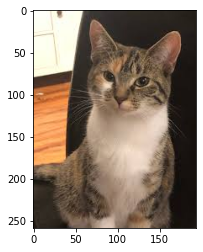

(259, 194, 3) 255 105.00341652403507 0


In [26]:
image_filename = 'image.jpg'

path = VIDEO_FOLDER + '/' + image_filename

img = cv2.imread(path)
img = flip_RGB(img)

plt.imshow(img)
plt.show()

print(img.shape, img.max(), img.mean(), img.min() )

In [27]:
# To tensor and normolize
img_norm = transforms.ToTensor()(img)
img_norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img_norm)
img_norm = img_norm.unsqueeze(0)

print(img_norm.shape, img_norm.max(), img_norm.mean(), img_norm.min())

torch.Size([1, 3, 259, 194]) tensor(1.) tensor(-0.1764) tensor(-1.)


In [28]:
# Pass Net
with torch.no_grad():
    G_AB.eval()
    Bfake = G_AB(img_norm)
    img_norm = img_norm.to('cpu'); Bfake = Bfake.to('cpu');

In [29]:
# To image and denormolize
img_recovered = Bfake.squeeze()
img_recovered = denorm(img_recovered)
img_recovered = img_recovered.permute(1,2,0)#.type(torch.int8)
print(img_recovered.shape, img_recovered.max(), img_norm.mean(), img_recovered.min())

torch.Size([260, 196, 3]) tensor(0.9938) tensor(-0.1764) tensor(0.0034)


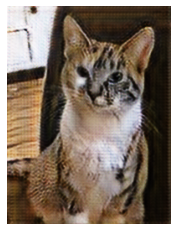

In [30]:
plt.axis('off')
plt.imshow(img_recovered)
plt.show()

In [31]:
# To CV2 image 
img_recovered = img_recovered * 255
img_recovered = flip_RGB(img_recovered) # flip RGB->BGR or BGR->RGB
img_recovered = np.array(img_recovered)
cv2.imwrite('samples/image_out.jpg', img_recovered)

True

## Convert video

In [32]:
IN_VIDEO_FILENAME = 'pexels-anastasia-shuraeva-7672693.mp4'
OUT_VIDEO_FILENAME = 'video_out.mp4'

image_net = 256

start_frame = 0 # start from frame N 20
lengh = 60 # in frames, 0 for max

In [33]:
in_video_path = VIDEO_FOLDER + '/' + IN_VIDEO_FILENAME
out_video_path = VIDEO_FOLDER + '/' + OUT_VIDEO_FILENAME

video_in = cv2.VideoCapture(in_video_path)

video_in_W = int(video_in.get(3))
video_in_H = int(video_in.get(4))
fps = video_in.get(cv2.CAP_PROP_FPS)
frames_count = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))

if video_in_W >= video_in_H:
    video_out_H = int(image_net)
    video_out_W = int(image_net * (video_in_W / video_in_H))
else:
    video_out_W = int(image_net)
    video_out_H = int(image_net * (video_in_H / video_in_W))  
    
print(f'Video in: {video_in_W}x{video_in_H}, fps:{fps}, frames:{frames_count}')
print(f'Video out: {video_out_W}x{video_out_H}')


fourcc = cv2.VideoWriter_fourcc('x', '2', '6', '4')
video_out = cv2.VideoWriter(out_video_path, 
                            fourcc, fps, 
                            (video_out_W, video_out_H))

transform_totensor = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ret = True
frame_n = 0
if lengh == 0: lengh = frames_count - start_frame

for i in tqdm(range(frames_count)):
    if frame_n >= start_frame and frame_n < (start_frame + lengh):
        # Read frame and resize
        ret, frame_in = video_in.read()
        frame_in = cv2.resize(frame_in,(256,256),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        frame_in = flip_RGB(frame_in)

        frame_in = transform_totensor(frame_in).unsqueeze(0)

        frame_out = get_fake(G_AB, frame_in, device) # input torch tensor, device default cpu

        # To image and denormolize
        frame_out = frame_out.squeeze()
        frame_out = denorm(frame_out, (0.5, 0.5, 0.5), (0.42, 0.42, 0.42))
        frame_out = transforms.Resize((video_out_H, video_out_W), transforms.functional.InterpolationMode.BICUBIC)(frame_out)
        frame_out = frame_out.permute(1,2,0)    
        frame_out = (frame_out * 255).type(torch.uint8)
        frame_out = np.array(frame_out)
        frame_out = flip_RGB(frame_out) 

        video_out.write(frame_out)
        
    frame_n += 1

video_in.release()
video_out.release()

Video in: 2160x3840, fps:23.976023976023978, frames:234
Video out: 256x455


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:43<00:00,  2.26it/s]


# Make GIF

In [34]:
from PIL import Image
from tqdm import tqdm

Define params. :

In [39]:
VIDEO_PATH = "samples"
IN_VIDEO_FILENAME = 'pexels-anastasia-shuraeva-7672693.mp4'
OUT_VIDEO_FILENAME = 'video_out.mp4'

GIFREAL_FILENAME = 'GIF_real.gif'
GIFFAKE_FILENAME = 'GIF_fake.gif'

image_net = 256

start_frame = 20 # start from frame N 20
lengh = 210 # in frames

Utils:

In [37]:
def make_GIF(images, folder, filename, n_loop = 0): # n_loop = 0 for inf. loops
    images[0].save(folder + '/' + filename,
                   save_all=True, 
                   append_images=images[1:], 
                   optimize=False, 
                   duration=frame_duration, 
                   loop=0)

Get images from video:

In [40]:
in_video_path = VIDEO_PATH + '/' + IN_VIDEO_FILENAME
out_video_path = VIDEO_PATH + '/' + OUT_VIDEO_FILENAME

video_in = cv2.VideoCapture(in_video_path)
frames_count = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))
frame_duration = 1 / video_in.get(cv2.CAP_PROP_FPS) * 1000 # frame duration

video_in_W = int(video_in.get(3))
video_in_H = int(video_in.get(4))

if video_in_W >= video_in_H:
    gif_H = int(image_net)
    gif_W = int(image_net * (video_in_W / video_in_H))
else:
    gif_W = int(image_net)
    gif_H = int(image_net * (video_in_H / video_in_W))  

images_real = []

ret = True
for i in range(frames_count):
    ret, frame = video_in.read()
    if i >= start_frame and i < (start_frame+lengh): # catch frames from start_frame
        frame = cv2.resize(frame,(gif_W, gif_H),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        frame = flip_RGB(frame)
        frame = Image.fromarray(frame)
        
        images_real.append(frame)
        
video_in.release()

In [41]:
images_real[0].size

(256, 455)

Make GIF from original frames

In [42]:
make_GIF(images_real, VIDEO_PATH, GIFREAL_FILENAME)

Make Fake images:

In [45]:
images_fake = []

for image in tqdm(images_real):  
# for image in images_real:
    
    image_W, image_H = image.size # pillow image size width x height
    
    tensor = transforms.ToTensor()(image)
    tensor = transforms.Resize((256, 256), transforms.functional.InterpolationMode.BICUBIC)(tensor)
    tensor = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(tensor)
    tensor = tensor.unsqueeze(0)
          
    tensor = get_fake(G_AB, tensor, device) # input torch tensor, device default cpu
            
    # To image and denormolize
    tensor = tensor.squeeze()
    tensor = denorm(tensor, (0.5, 0.5, 0.5), (0.42, 0.42, 0.42))
    tensor = transforms.Resize((image_H, image_W), transforms.functional.InterpolationMode.BICUBIC)(tensor)
    image_fake = tensor.permute(1,2,0)    
    image_fake = (image_fake * 255).type(torch.uint8)
    image_fake = np.array(image_fake)
    image_fake = Image.fromarray(image_fake, "RGB")
    
    images_fake.append(image_fake)
    
#     break

100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [06:18<00:00,  1.80s/it]


Make GIF from fake frames

In [46]:
make_GIF(images_fake, VIDEO_PATH, GIFFAKE_FILENAME)